In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

import torch

import torch.nn as nn

import torch.nn.functional as F

from nltk.corpus import stopwords

from collections import Counter

import string

import re

import seaborn as sns

from tqdm import tqdm

import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
data = pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [4]:
X = data['review'].values
y = data['sentiment'].values

In [6]:
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
x_train.shape

(37500,)

In [7]:
stop_words = set(stopwords.words('english'))
len(stop_words)

179

In [8]:
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s)
    s = re.sub(r"\s+", '', s)
    s = re.sub(r"\d", '', s)

    return s

def tokenize(x_train,y_train,x_test,y_test):
    word_list = []

    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)

    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]

    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}


    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_test:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])

    encoded_train = [1 if label =='positive' else 0 for label in y_train]
    encoded_test = [1 if label =='positive' else 0 for label in y_test]
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [9]:
x_train,y_train,x_test,y_test,vocab = tokenize(x_train,y_train,x_test,y_test)

<ipython-input-8-4994f5d1ee8b>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [15]:
max_train = 0
max_test = 0
for each in x_train:
  max_train = max(max_train, len(each))
for each in x_test:
  max_test = max(max_test, len(each))
print("max_train: ", max_train)
print("max_test: ", max_test)

max_train:  653
max_test:  549


In [16]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for index, review in enumerate(sentences):
        if len(review) != 0:
            features[index, -len(review):] = np.array(review)[:seq_len]
    return features

In [17]:
x_train_pad = padding_(x_train,650)
x_test_pad = padding_(x_test,650)

In [18]:
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

#forward NN

In [114]:
import torch
import torch.nn as nn

class FeedforwardNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, no_layers=2, drop_prob=0.5):
        super(FeedforwardNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drop_prob)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        embedded_mean = torch.mean(embedded, dim=1)

        x = self.fc1(embedded_mean)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


In [115]:
no_layers = 2
vocab_size = len(vocab) + 1
embedding_dim = 64
output_dim = 1
hidden_dim = 256

In [116]:
model = FeedforwardNN(vocab_size, embedding_dim, hidden_dim, output_dim, no_layers, drop_prob=0.5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

FeedforwardNN(
  (embedding): Embedding(1001, 64)
  (fc1): Linear(in_features=64, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [117]:
criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [118]:
clip = 5
epochs = 5
valid_loss_min = np.Inf

epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(inputs)

        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())

        accuracy = acc(output, labels)
        train_acc += accuracy
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    val_losses = []
    val_acc = 0.0
    model.eval()

    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        output = model(inputs)
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())

        accuracy = acc(output, labels)
        val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)

    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)


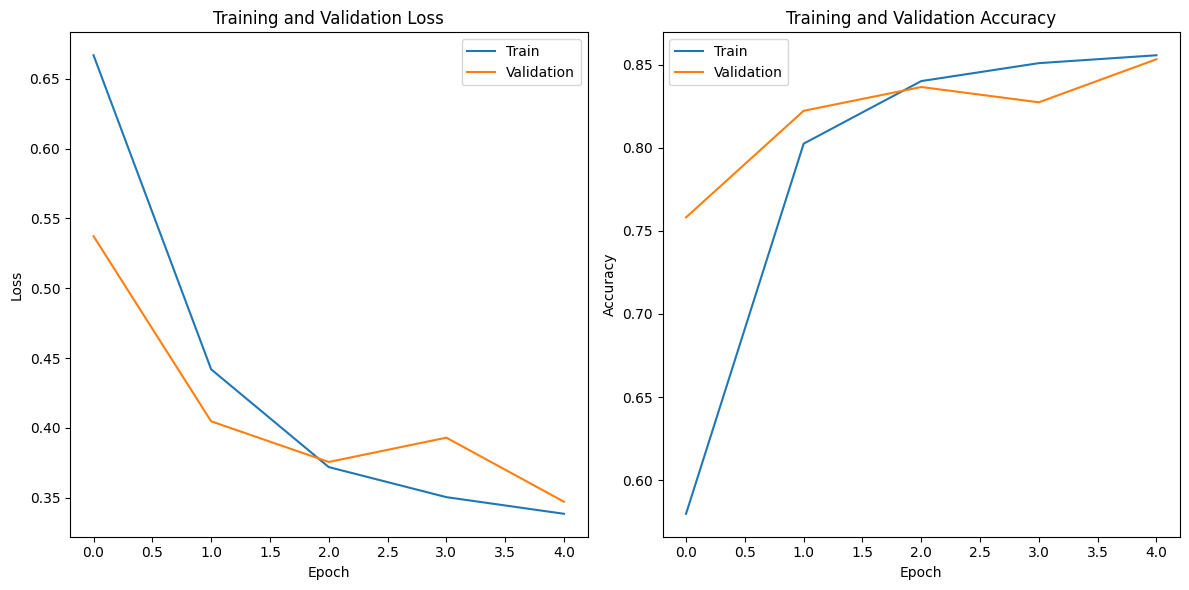

In [107]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_loss, label='Train')
plt.plot(epoch_vl_loss, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_acc, label='Train')
plt.plot(epoch_vl_acc, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [26]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,650))
        inputs = pad.to(device)
        batch_size = 1
        output = model(inputs)
        return(output.item())

In [30]:
import random
index = random.randint(0, 49999)
print(data['review'][index])
print('='*70)
print(f'Actual sentiment is  : {data["sentiment"][index]}')
print('='*70)
pro = predict_text(data['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

I recalled watching this program as a young boy in Australia in the 60s, and enjoyed it on DVD again as a 50-year-old father of young kids. Although the bad guys are mostly shallow characters and there is a component of violence, I am very happy to have my 6- and 8-year old kids watch this because the central characters are deep, kind and honourable, the Japanese culture shines through, the violence is not gory, nobody glories in it, and the program is beautiful to watch. It does not promote nightmares, but instead it shows much of the culture that must have primarily influenced the design of Jedi knights in Star Wars. <br /><br />The quality of the DVDs does leave something to be desired. Video perfectionists will not like this one. It is strongly reminiscent of something held on 16mm film and projected onto the wall in some basement... which it may well be. The soundtrack is also lacking in the quality we have come to expect from home theatre. However, my kids noticed only that it wa

# simple RNN

In [63]:
import torch
import torch.nn as nn

class RNN_model(nn.Module):
    def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, output_dim, drop_prob=0.5):
        super(RNN_model, self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.no_layers = no_layers
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=self.hidden_dim, num_layers=no_layers, batch_first=True)

        self.dropout = nn.Dropout(drop_prob)

        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)

        embeds = self.embedding(x)
        rnn_out, hidden = self.rnn(embeds, hidden)

        rnn_out = rnn_out.contiguous().view(-1, self.hidden_dim)

        out = self.dropout(rnn_out)
        out = self.fc(out)

        sig_out = self.sig(out)


        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]


        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''

        h0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        hidden = h0
        return hidden



In [64]:
no_layers = 2
vocab_size = len(vocab) + 1
embedding_dim = 64
output_dim = 1
hidden_dim = 256

In [65]:
model = RNN_model(no_layers,vocab_size,hidden_dim,embedding_dim,output_dim, drop_prob=0.3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

RNN_model(
  (embedding): Embedding(1001, 64)
  (rnn): RNN(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [66]:
criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [67]:
clip = 5
epochs = 5
valid_loss_min = np.Inf

epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    h = model.init_hidden(batch_size)

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        h = h.detach()

        model.zero_grad()
        output, h = model(inputs, h)

        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())

        accuracy = acc(output, labels)
        train_acc += accuracy
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = val_h.detach()

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

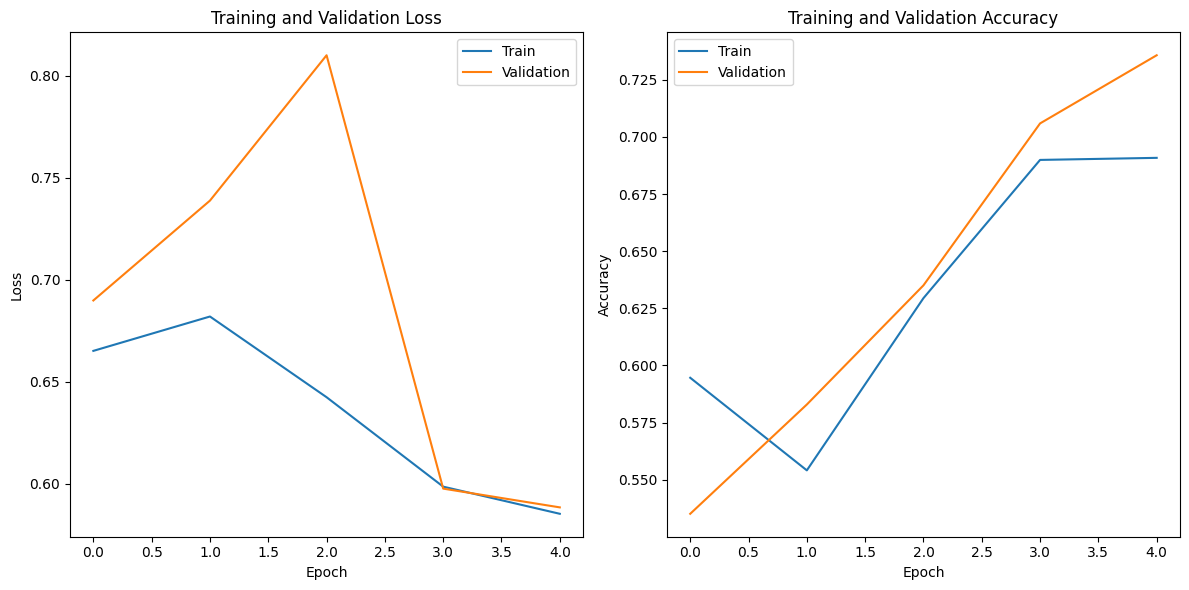

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_loss, label='Train')
plt.plot(epoch_vl_loss, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_acc, label='Train')
plt.plot(epoch_vl_acc, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [69]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,650))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = h.detach()
        output, h = model(inputs, h)
        return(output.item())

In [70]:
import random
index = random.randint(0, 49999)
print(data['review'][index])
print('='*70)
print(f'Actual sentiment is  : {data["sentiment"][index]}')
print('='*70)
pro = predict_text(data['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

In reply to "State of Confusion" The dogs injuries do seem to disappear rather abruptly, but that may have only been an error in continuity. But, as for the kids trying to build a plane out of junk, it's just a simple matter of imagination. These are two very young kids who have extremely active imaginations and they must rely on those imaginations to keep themselves from being exposed to the reality of the level of abuse that goes on in their home from their stepfather. As for the stepfather, it's very interesting that the director chose to no show his face. That makes him seem more monstrous. If you show his face, then that character becomes a person and not just this "monster" who is terrorizing the childhood of these two innocent children. By showing only the concequences of his abuse and not focusing scenes on the abuse itself, the children then become the main focus of the movie. This film has no loose ends, but runs just as a father's tale to his children would. It has embellesh

#GRU

In [119]:
import torch
import torch.nn as nn

class GRU_Model(nn.Module):
    def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, output_dim, drop_prob=0.5):
        super(GRU_Model, self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.no_layers = no_layers
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=self.hidden_dim, num_layers=no_layers, batch_first=True)

        self.dropout = nn.Dropout(drop_prob)

        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)

        embeds = self.embedding(x)
        gru_out, hidden = self.gru(embeds, hidden)

        gru_out = gru_out.contiguous().view(-1, self.hidden_dim)

        out = self.dropout(gru_out)
        out = self.fc(out)

        sig_out = self.sig(out)

        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]

        return sig_out, hidden


    def init_hidden(self, batch_size):

            h0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
            hidden = h0
            return hidden



In [120]:
no_layers = 2
vocab_size = len(vocab) + 1
embedding_dim = 64
output_dim = 1
hidden_dim = 256


In [121]:
model = GRU_Model(no_layers, vocab_size, hidden_dim, embedding_dim, output_dim, drop_prob=0.9)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

GRU_Model(
  (embedding): Embedding(1001, 64)
  (gru): GRU(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.9, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [122]:
criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [123]:
clip = 5
epochs = 5
valid_loss_min = np.Inf

epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    h = model.init_hidden(batch_size)

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        h = h.detach()

        model.zero_grad()
        output, h = model(inputs, h)

        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())

        accuracy = acc(output, labels)
        train_acc += accuracy
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = val_h.detach()

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

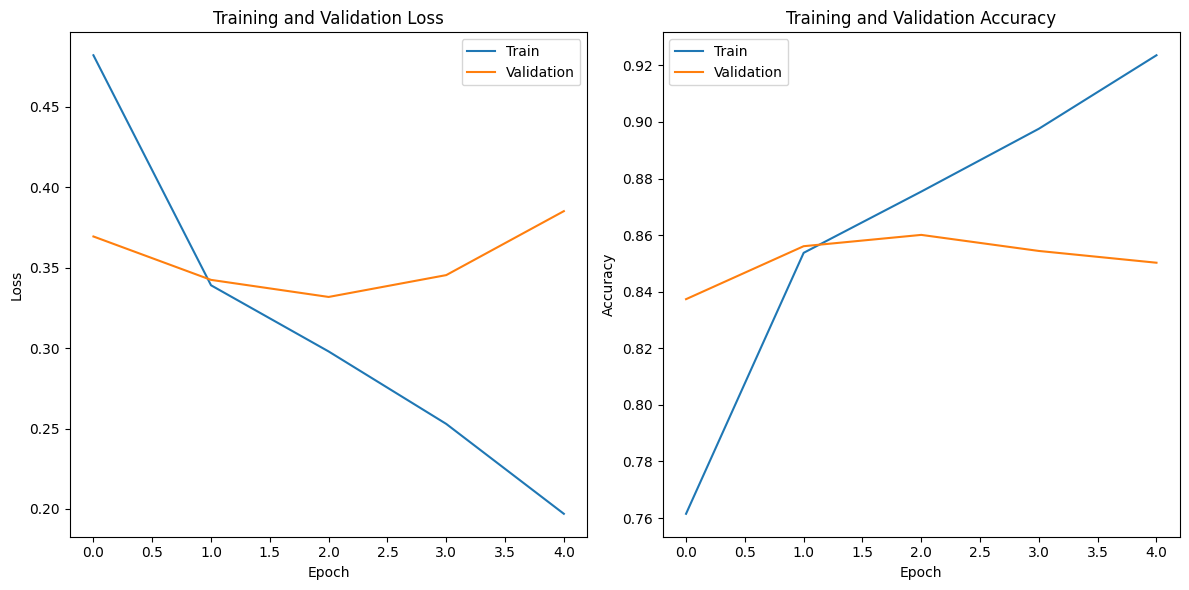

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_loss, label='Train')
plt.plot(epoch_vl_loss, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_acc, label='Train')
plt.plot(epoch_vl_acc, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [140]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,650))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = h.detach()
        output, h = model(inputs, h)
        return(output.item())

In [86]:
import random
index = random.randint(0, 49999)
print(data['review'][index])
print('='*70)
print(f'Actual sentiment is  : {data["sentiment"][index]}')
print('='*70)
pro = predict_text(data['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

I am at a distinct disadvantage here. I have not seen the first two movies in this series, although I have seen a lot of Larry Cohen films. Fans of the series seem to think this is a good film. Judging it on it's own, it was pretty boring.<br /><br />You never get a real good look at the maniac cop's (Robert Z'Dar) face, but what I did see was pretty grim. The death scenes seem to be staged to eat up the most film, not to give any thrills. Maybe if I saw the NC-17 Director's Cut, I may be more impressed.<br /><br />The ending with the car chase with Z'Dar, Caitlin Dulany, and Robert Davi was pretty intense. best part of the movie.
Actual sentiment is  : negative
Predicted sentiment is positive with a probability of 0.5032844543457031


#LSTM

In [88]:
class LSTM_model(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(LSTM_model,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim, num_layers=no_layers, batch_first=True)


        self.dropout = nn.Dropout(drop_prob)


        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)

        embeds = self.embedding(x)

        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = self.sig(out)

        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1]


        return sig_out, hidden


    def init_hidden(self, batch_size):

        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [89]:
no_layers = 2
vocab_size = len(vocab) + 1
embedding_dim = 64
output_dim = 1
hidden_dim = 256

In [90]:
model = LSTM_model(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

LSTM_model(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [91]:
criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [92]:
clip = 5
epochs = 5
valid_loss_min = np.Inf

epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    h = model.init_hidden(batch_size)

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])

        model.zero_grad()
        output, h = model(inputs, h)

        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())

        accuracy = acc(output, labels)
        train_acc += accuracy
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

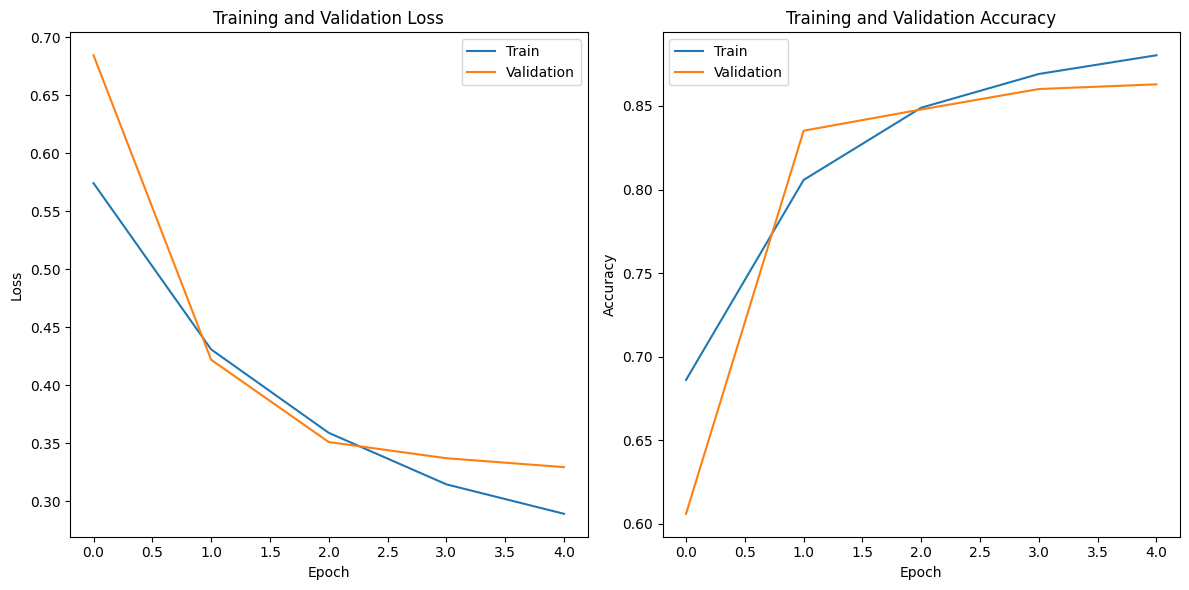

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_loss, label='Train')
plt.plot(epoch_vl_loss, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_acc, label='Train')
plt.plot(epoch_vl_acc, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [95]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,650))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [96]:
import random
index = random.randint(0, 49999)
print('='*70)
print(f'Actual sentiment is  : {data["sentiment"][index]}')
print('='*70)
pro = predict_text(data['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Actual sentiment is  : negative
Predicted sentiment is negative with a probability of 0.9782903604209423
